<a href="https://colab.research.google.com/github/MarioAvolio/102-Category-Flower-Dataset-with-Keras/blob/main/BiT_Flowers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Flowers Analysis
http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html

102 Flower Category Database
----------------------------------------------
This set contains images of flowers belonging to 102 different categories. 
The images were acquired by searching the web and taking pictures. There are a
minimum of 40 images for each category.

The images are contained in the file 102flowers.tgz and the image labels in
imagelabels.mat.

We provide 4 distance matrices. D_hsv, D_hog, D_siftint, D_siftbdy. These
are the chi^2 distance matrices used in the publication below.

The database was used in:

Nilsback, M-E. and Zisserman, A. Automated flower classification over a large number of classes.
Proceedings of the Indian Conference on Computer Vision, Graphics and Image Processing (2008) 
http://www.robots.ox.ac.uk/~vgg/publications/papers/nilsback08.{pdf,ps.gz}.

Datasplit
------------------------------------------------
The datasplits used in this paper are specified in setid.mat.

The results in the paper are produced on a 103 category database. The two
categories labeled Petunia have since been merged since they are the same.
There is a training file (trnid), a validation file (valid)
and a testfile (tstid). 

Segmentation Images
------------------------------------------------
We provide the segmentations for the images in the file 102segmentations.tgz

More details can be found in:

Nilsback, M-E. and Zisserman, A. Delving into the whorl of flower segmenation.
Proceedings of the British Machine Vision Conference (2007)
http:www.robots.ox.ac.uk/~vgg/publications/papers/nilsback07.(pdf,ps.gz).
.

History
-----------------------------------------------
version 1.1 - Two petunia categories merged into one. 

# BiT - Big Transfer

Transfer of pre-trained representations improves sample efficiency and simplifies hyperparameter tuning when training deep neural networks for vision. We revisit the paradigm of pre-training on large supervised datasets and fine-tuning the model on a target task. We scale up pre-training, and propose a simple recipe that we call Big Transfer (BiT). By combining a few carefully selected components, and transferring using a simple heuristic, we achieve strong performance on over 20 datasets. BiT performs well across a surprisingly wide range of data regimes -- from 1 example per class to 1M total examples. BiT achieves 87.5% top-1 accuracy on ILSVRC-2012, 99.4% on CIFAR-10, and 76.3% on the 19 task Visual Task Adaptation Benchmark (VTAB). On small datasets, BiT attains 76.8% on ILSVRC-2012 with 10 examples per class, and 97.0% on CIFAR-10 with 10 examples per class. We conduct detailed analysis of the main components that lead to high transfer performance.

> Title: Big Transfer (BiT): General Visual Representation Learning 
>> Paper: https://arxiv.org/abs/1912.11370

> -- <cite>Alexander Kolesnikov, Lucas Beyer, Xiaohua Zhai, Joan Puigcerver, Jessica Yung, Sylvain Gelly, Neil Houlsby</cite>

In [1]:
#@title Imports
import tensorflow as tf
import tensorflow_hub as hub

import tensorflow_datasets as tfds

import time


from PIL import Image
import requests
from io import BytesIO

import matplotlib.pyplot as plt
import numpy as np

import os
import pathlib
import sklearn


Number of flower types 102
Number of training examples: 1020
Number of validation examples: 1020
Number of test examples: 6149

Flower types full list:
['pink primrose', 'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea', 'english marigold', 'tiger lily', 'moon orchid', 'bird of paradise', 'monkshood', 'globe thistle', 'snapdragon', "colt's foot", 'king protea', 'spear thistle', 'yellow iris', 'globe-flower', 'purple coneflower', 'peruvian lily', 'balloon flower', 'giant white arum lily', 'fire lily', 'pincushion flower', 'fritillary', 'red ginger', 'grape hyacinth', 'corn poppy', 'prince of wales feathers', 'stemless gentian', 'artichoke', 'sweet william', 'carnation', 'garden phlox', 'love in the mist', 'mexican aster', 'alpine sea holly', 'ruby-lipped cattleya', 'cape flower', 'great masterwort', 'siam tulip', 'lenten rose', 'barbeton daisy', 'daffodil', 'sword lily', 'poinsettia', 'bolero deep blue', 'wallflower', 'marigold', 'buttercup', 'oxeye daisy', 'common dandelion'

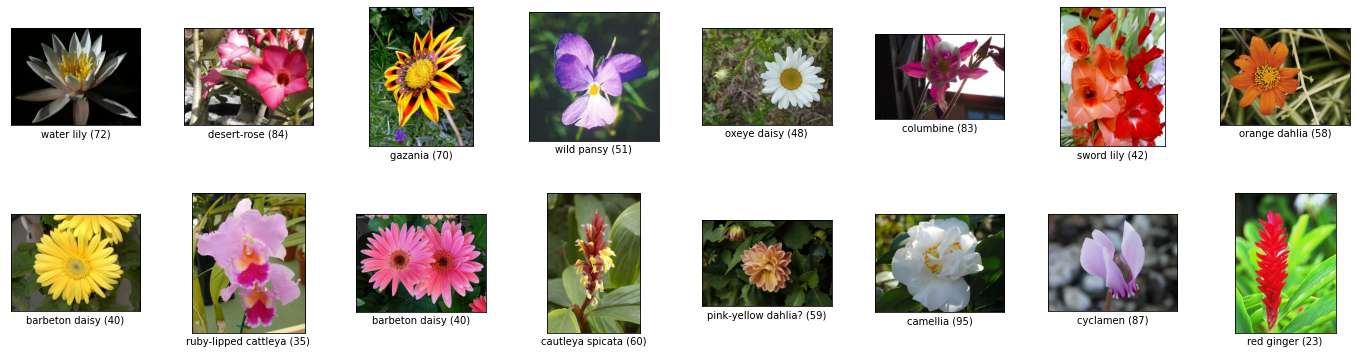

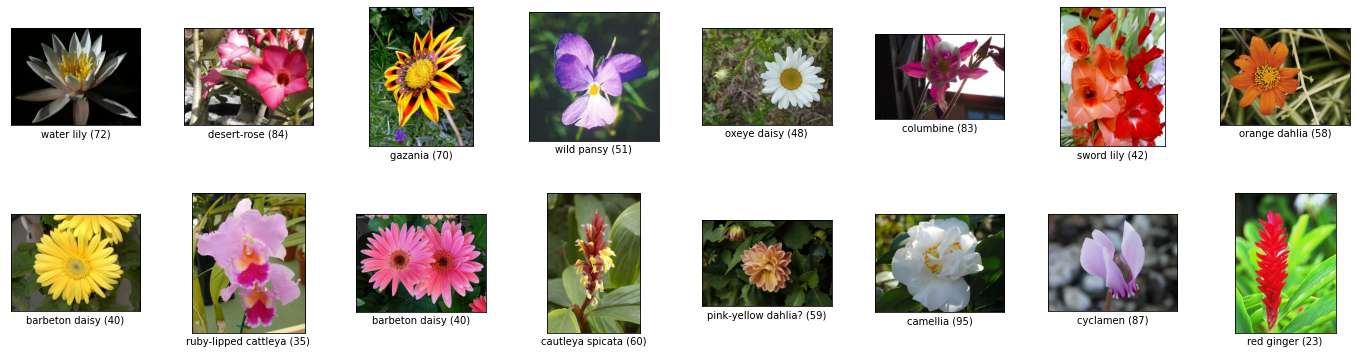

In [2]:
ds_name = 'oxford_flowers102'
splits = ['test', 'train', 'validation']
ds, info = tfds.load(ds_name, split = splits, with_info=True)
(test_examples, train_examples, validation_examples) = ds
print(f"Number of flower types {info.features['label'].num_classes}")
print(f"Number of training examples: {tf.data.experimental.cardinality(train_examples)}")
print(f"Number of validation examples: {tf.data.experimental.cardinality(validation_examples)}")
print(f"Number of test examples: {tf.data.experimental.cardinality(test_examples)}\n")

print('Flower types full list:')
print(info.features['label'].names)

tfds.show_examples(train_examples, info, rows=2, cols=8)

In [3]:
test_examples

<PrefetchDataset element_spec={'file_name': TensorSpec(shape=(), dtype=tf.string, name=None), 'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>

## Model

In [4]:
# Load model into KerasLayer
model_url = "https://tfhub.dev/google/bit/m-r152x4/1"
module = hub.KerasLayer(model_url)

## Fine-tuning the BiT model

Now we are going to fine-tune the BiT model so it performs better on a specific dataset. Here we are going to use Keras for simplicity and we are going to fine-tune the model on a dataset of flowers (`tf_flowers`). 

We will use the model we loaded at the start (i.e. the one not fine-tuned on ImageNet) so the model is less biased towards ImageNet-like images.

There are two steps:
1. Create a new model with a new final layer (which we call the ‘head’), and
2. Fine-tune this model using BiT-HyperRule, our hyperparameter heuristic.


### 1. Creating the new model



To create the new model, we:

1. Cut off the BiT model’s original head. This leaves us with the “pre-logits” output.
 - We do not have to do this if we use the ‘feature extractor’ models ((i.e. all those in subdirectories titled `feature_vectors`), since for those models the head has already been cut off.

2. Add a new head with the number of outputs equal to the number of classes of our new task. Note that it is important that we initialise the head to all zeroes.

#### Add new head to the BiT model

Since we want to use BiT on a new dataset (not the one it was trained on), we need to replace the final layer with one that has the correct number of output classes. This final layer is called the head.

Note that it is important to **initialise the new head to all zeros**.

In [5]:
# Add new head to the BiT model

class MyBiTModel(tf.keras.Model):
  """BiT with a new head."""

  def __init__(self, num_classes, module):
    super().__init__()

    self.num_classes = num_classes
    self.head = tf.keras.layers.Dense(num_classes, kernel_initializer='zeros')#, activation = "softmax")
    self.bit_model = module
  
  def call(self, images):
    # No need to cut head off since we are using feature extractor model
    bit_embedding = self.bit_model(images)
    return self.head(bit_embedding)

model = MyBiTModel(num_classes=102, module=module)

### Data and preprocessing




#### BiT Hyper-Rule: Our hyperparameter selection heuristic
When we fine-tune the model, we use BiT-HyperRule, our heuristic for choosing hyperparameters for downstream fine-tuning. This is **not a hyperparameter sweep** - given a dataset, it specifies one set of hyperparameters that we’ve seen produce good results. You can often obtain better results by running a more expensive hyperparameter sweep, but BiT-HyperRule is an effective way of getting good initial results on your dataset.

**Hyperparameter heuristic details**

In BiT-HyperRule, we use a vanilla SGD optimiser with an initial learning rate of 0.003, momentum 0.9 and batch size 512. We decay the learning rate by a factor of 10 at 30%, 60% and 90% of the training steps. 

As data preprocessing, we resize the image, take a random crop, and then do a random horizontal flip (details in table below). We do random crops and horizontal flips for all tasks except those where such actions destroy label semantics. E.g. we don’t apply random crops to counting tasks, or random horizontal flip to tasks where we’re meant to predict the orientation of an object.


Image area | Resize to | Take random crop of size
--- | --- | ---
Smaller than 96 x 96 px | 160 x 160 px | 128 x 128 px
At least 96 x 96 px | 512 x 512 px | 480 x 480 px

*Table 1: Downstream resizing and random cropping details. If images are larger, we resize them to a larger fixed size to take advantage of benefits from fine-tuning on higher resolution.*


We also use MixUp for datasets with more than 20k examples. Since the dataset used in this tutorial does not use MixUp, for simplicity and speed, we do not include it in this colab, but include it in our [github repo implementation](https://github.com/google-research/big_transfer).

In [6]:
#@title Set dataset-dependent hyperparameters

#@markdown Here we set dataset-dependent hyperparameters. For example, our dataset of flowers has 3670 images of varying size (a few hundred x a few hundred pixels), so the image size is larger than 96x96 and the dataset size is <20k examples. However, for speed reasons (since this is a tutorial and we are training on a single GPU), we will select the `<96x96 px` option and train on lower resolution images. As we will see, we can still attain strong results.

#@markdown **Algorithm details: how are the hyperparameters dataset-dependent?** 

#@markdown It's quite intuitive - we resize images to a smaller fixed size if they are smaller than 96 x 96px and to a larger fixed size otherwise. The number of steps we fine-tune for is larger for larger datasets. 

IMAGE_SIZE = "=\u003C96x96 px" #@param ["=<96x96 px","> 96 x 96 px"]
DATASET_SIZE = "\u003C20k examples" #@param ["<20k examples", "20k-500k examples", ">500k examples"]

if IMAGE_SIZE == "=<96x96 px":
  RESIZE_TO = 160
  CROP_TO = 128
else:
  RESIZE_TO = 512
  CROP_TO = 480

if DATASET_SIZE == "<20k examples":
  SCHEDULE_LENGTH = 500
  SCHEDULE_BOUNDARIES = [200, 300, 400]
elif DATASET_SIZE == "20k-500k examples":
  SCHEDULE_LENGTH = 10000
  SCHEDULE_BOUNDARIES = [3000, 6000, 9000]
else:
  SCHEDULE_LENGTH = 20000
  SCHEDULE_BOUNDARIES = [6000, 12000, 18000]

**Tip**: if you are running out of memory, decrease the batch size. A way to adjust relevant parameters is to linearly scale the schedule length and learning rate.

```
SCHEDULE_LENGTH = SCHEDULE_LENGTH * 512 / BATCH_SIZE
lr = 0.003 * BATCH_SIZE / 512
```

These adjustments have already been coded in the cells below - you only have to change the `BATCH_SIZE`. If you change the batch size, please re-run the cell above as well to make sure the `SCHEDULE_LENGTH` you are starting from is correct as opposed to already altered from a previous run.

In [7]:
DATASET_NUM_TRAIN_EXAMPLES = tf.data.experimental.cardinality(train_examples).numpy()
DATASET_NUM_TRAIN_EXAMPLES

1020

In [8]:
# Preprocessing helper functions

# Create data pipelines for training and testing:
BATCH_SIZE = 32
SCHEDULE_LENGTH = SCHEDULE_LENGTH * 512 / BATCH_SIZE

STEPS_PER_EPOCH = 10


def cast_to_tuple(features):
  return (features['image'], features['label'])
  
def preprocess_train(features):
  # Apply random crops and horizontal flips for all tasks 
  # except those for which cropping or flipping destroys the label semantics
  # (e.g. predict orientation of an object)
  features['image'] = tf.image.random_flip_left_right(features['image'])
  features['image'] = tf.image.resize(features['image'], [RESIZE_TO, RESIZE_TO])
  features['image'] = tf.image.random_crop(features['image'], [CROP_TO, CROP_TO, 3])
  features['image'] = tf.cast(features['image'], tf.float32) / 255.0
  print(features['image'])
  return features

def preprocess_test(features):
  features['image'] = tf.image.resize(features['image'], [RESIZE_TO, RESIZE_TO])
  features['image'] = tf.cast(features['image'], tf.float32) / 255.0
  return features

# """
# A sequence of data processing components is called a data pipeline. Pipelines are very
# common in machine learning systems, since there is a lot of data to manipulate and
# many data transformations to apply.
# Components typically run asynchronously. Each component pulls in a large amount
# of data, processes it, and spits out the result in another data store. Then, some time
# later, the next component in the pipeline pulls in this data and spits out its own
# output. Each component is fairly self-contained: the interface between components
# is simply the data store. This makes the system simple to grasp (with the help of a
# data flow graph), and different teams can focus on different components. Moreover,
# if a component breaks down, the downstream components can often continue to
# run normally (at least for a while) by just using the last output from the broken
# component. This makes the architecture quite robust.
# On the other hand, a broken component can go unnoticed for some time if proper
# monitoring is not implemented. The data gets stale and the overall system’s performance
# drops.
# """

# PIPELINE TRANSFORMATION
pipeline_train = (train_examples
                  # shuffle() will create a new
                  # dataset that will start by filling up a buffer with the first items of the source dataset.
                  # Then, whenever it is asked for an item, it will pull one out randomly from the buffer
                  # and replace it with a fresh one from the source dataset, until it has iterated entirely
                  # through the source dataset. At this point it will continue to pull out items randomly
                  # from the buffer until it is empty. You must specify the buffer size, and it is important
                  # to make it large enough, or else shuffling will not be very effective.1 Just don’t exceed
                  # the amount of RAM you have, though even if you have plenty of it, there’s no need
                  # to go beyond the dataset’s size. You can provide a random seed if you want the same
                  # random order every time you run your program.
                  .shuffle(10000)

                  # we first call the repeat() method on the original dataset, and it
                  # returns a new dataset that repeats the items of the original dataset N times. Of
                  # course, this will not copy all the data in memory N times!
                  .repeat(int(SCHEDULE_LENGTH * BATCH_SIZE / DATASET_NUM_TRAIN_EXAMPLES * STEPS_PER_EPOCH) + 1 + 50)  # repeat dataset_size / num_steps

                  # This map() method is the one you will call to apply any preprocessing to your
                  # data. Sometimes this will include computations that can be quite intensive, such as
                  # reshaping or rotating an image, so you will usually want to spawn multiple threads to
                  # speed things up. This can be done by setting the num_parallel_calls argument to
                  # the number of threads to run, or to tf.data.AUTOTUNE.
                  .map(preprocess_train, num_parallel_calls=tf.data.AUTOTUNE) # or 8
                  
                  # Then we call the batch() method on this new dataset, and again this creates a new
                  # dataset. This one will group the items of the previous dataset in batches of N
                  # items.
                  .batch(BATCH_SIZE)
                  .map(cast_to_tuple)  # for keras model.fit

                  # Note that we use the prefetch() method on the very last line. This is important for performance
                  # By calling prefetch() at the end of the function,
                  # we are creating a dataset that will do its best to always be one batch ahead. In
                  # other words, while our training algorithm is working on one batch, the dataset will
                  # already be working in parallel on getting the next batch ready (e.g., reading the data
                  # from disk and preprocessing it). This can improve performance dramatically
                  .prefetch(tf.data.AUTOTUNE) # else 2
                  )

pipeline_test = (validation_examples.map(preprocess_test, num_parallel_calls=tf.data.AUTOTUNE) # else 1
                  .map(cast_to_tuple)  # for keras model.fit
                  .batch(BATCH_SIZE)
                  .prefetch(tf.data.AUTOTUNE) # 2
                  )

# 
# In a Jupyter notebook, if you import sklearn and run sklearn.
# set_config(display="diagram"), all Scikit-Learn estimators will
# be rendered as interactive diagrams. This is particularly useful for
# visualizing pipelines. To visualize num_pipeline, run a cell with
# num_pipeline as the last line. Clicking an estimator will show more
# details
# # 
# sklearn.set_config(display="diagram")

Tensor("truediv:0", shape=(128, 128, 3), dtype=float32)


### Fine-tuning loop

The fine-tuning will take about 15 minutes. If you wish, you can manually set the number of epochs to be 10 instead of 50 for the tutorial, and you will likely still obtain a model with validation accuracy > 99%.

In [9]:
# Define optimiser and loss

# When using the SGD optimizer, it is important to tune the learning
# rate. So, you will generally want to use optimizer=tf.keras.
# optimizers.SGD(learning_rate=__???__) to set the learning rate,
# rather than optimizer="sgd", which defaults to a learning rate of
# 0.01.

lr = 0.003 * BATCH_SIZE / 512 

# Decay learning rate by a factor of 10 at SCHEDULE_BOUNDARIES.
lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(boundaries=SCHEDULE_BOUNDARIES, 
                                                                   values=[lr, lr*0.1, lr*0.001, lr*0.0001])

optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9) # we can try with learning_rate=__???__

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)


In [10]:
model.compile(optimizer=optimizer,
              loss=loss_fn,
              metrics=['accuracy'])

# Fine-tune model
try:
  history = model.fit( 
    pipeline_train,
    batch_size=BATCH_SIZE,
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs= 10, #int(SCHEDULE_LENGTH / STEPS_PER_EPOCH),  # TODO: replace with `epochs=10` here to shorten fine-tuning for tutorial if you wish
    validation_data=pipeline_test  # here we are only using 
                                   # this data to evaluate our performance
  )
except e:
  print(e)

Epoch 1/10
10/10 [==============================] - 138s 10s/step - loss: 4.4567 - accuracy: 0.0750 - val_loss: 4.0171 - val_accuracy: 0.2745
Epoch 2/10
10/10 [==============================] - 77s 8s/step - loss: 3.7060 - accuracy: 0.4031 - val_loss: 2.7668 - val_accuracy: 0.7216
Epoch 3/10
10/10 [==============================] - 76s 8s/step - loss: 2.5403 - accuracy: 0.7844 - val_loss: 1.6920 - val_accuracy: 0.9265
Epoch 4/10
10/10 [==============================] - 77s 8s/step - loss: 1.0222 - accuracy: 0.9781 - val_loss: 1.0236 - val_accuracy: 0.9431
Epoch 5/10
10/10 [==============================] - 77s 8s/step - loss: 0.6045 - accuracy: 0.9875 - val_loss: 0.6330 - val_accuracy: 0.9657
Epoch 6/10
10/10 [==============================] - 77s 8s/step - loss: 0.3719 - accuracy: 0.9937 - val_loss: 0.4651 - val_accuracy: 0.9824
Epoch 7/10
10/10 [==============================] - 76s 8s/step - loss: 0.2112 - accuracy: 0.9937 - val_loss: 0.3994 - val_accuracy: 0.9794
Epoch 8/10
10/10 [

We see that our model attains over 98-99% training and validation accuracy.

In [11]:
# plot_history(history)

NameError: ignored